In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import gc
import re
import warnings
import random
from tqdm import tqdm

from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from bs4 import BeautifulSoup

import distance
from fuzzywuzzy import fuzz
from wordcloud import WordCloud, STOPWORDS
from PIL import Image

from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler, normalize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import spacy

warnings.filterwarnings("ignore")
sns.set_style('darkgrid')
%matplotlib inline

In [2]:
# reading the data
train_path = './data/train.csv'
df = pd.read_csv(train_path)

In [3]:
# number of records
print(f"Number of records: {df.shape[0]}")

Number of records: 404290


In [4]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


- 2 null values in column 'question2'
- 1 null value in column 'question1'

In [6]:
# plotting the distribution of the labels
df.groupby('is_duplicate')['id'].count()

is_duplicate
0    255027
1    149263
Name: id, dtype: int64

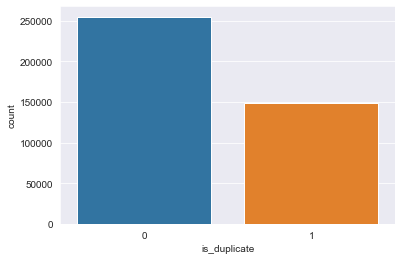

In [7]:
plt.figure()
sns.countplot(x='is_duplicate', data=df)
plt.show();

In [8]:
is_duplicate_0 = df[df['is_duplicate'] == 0].count()['id']
is_duplicate_1 = df[df['is_duplicate'] == 1].count()['id']

print(f"-> Question pairs which are not similar (is_duplicate=0):\n   {(is_duplicate_0/df.shape[0]):.2%}")
print(f"-> Question pairs which are similar (is_duplicate=1):\n   {(is_duplicate_1/df.shape[0]):.2%}")

-> Question pairs which are not similar (is_duplicate=0):
   63.08%
-> Question pairs which are similar (is_duplicate=1):
   36.92%


###### Finding Number of Unique Questions

In [9]:
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)

In [10]:
print(f"Total number of unique Questions are: {unique_qs}\n")
print(f"Number of unique questions that appear more than once: {qs_morethan_onetime} ({(qs_morethan_onetime/unique_qs):.2%})\n")
print(f"Max number of times a unique question is repeated: {max(qids.value_counts())}")

Total number of unique Questions are: 537933

Number of unique questions that appear more than once: 111780 (20.78%)

Max number of times a unique question is repeated: 157


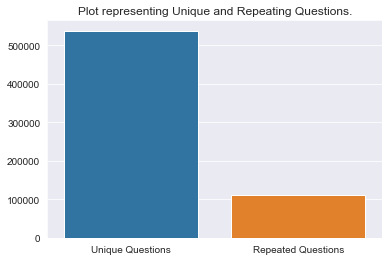

In [11]:
# plotting the values

x = ['Unique Questions', 'Repeated Questions']
y = [unique_qs, qs_morethan_onetime]

plt.figure()
sns.barplot(x=x, y=y)
plt.title("Plot representing Unique and Repeating Questions.")
plt.show();

###### Checking for Duplicates

In [12]:
pair_duplicates = df[df.duplicated(['qid1', 'qid2', 'is_duplicate'])]

In [13]:
pair_duplicates

,id,qid1,qid2,question1,question2,is_duplicate


In [14]:
print(f"There are {pair_duplicates.shape[0]} duplicate records in the Data.")

There are 0 duplicate records in the Data.


###### Plotting the number of times a Question is asked.

In [15]:
qids.value_counts()

2559      157
30782     120
4044      111
2561       88
14376      79
         ... 
416446      1
416444      1
416441      1
416439      1
537933      1
Length: 537933, dtype: int64

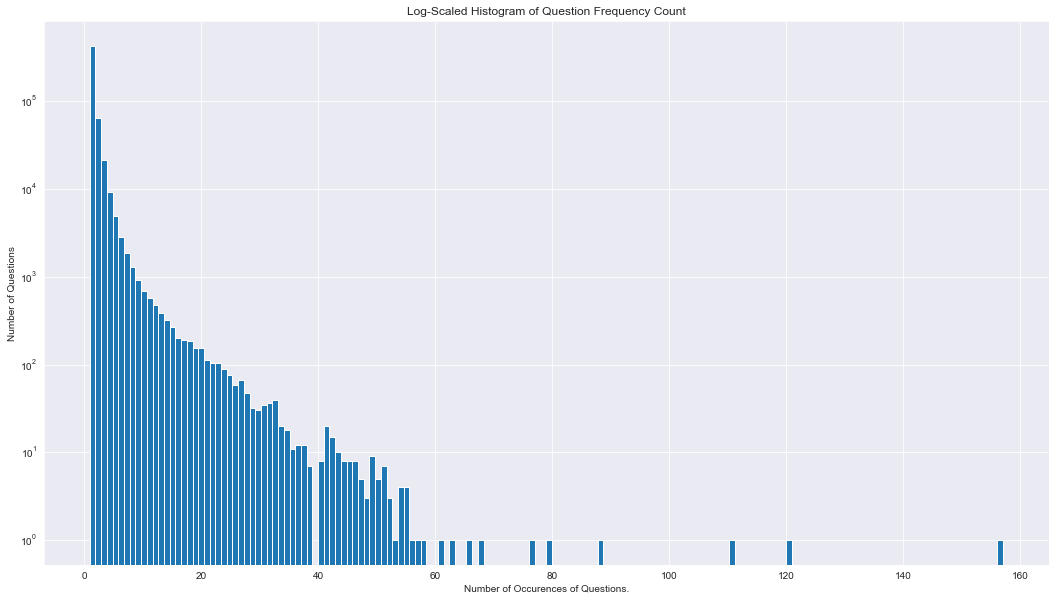

In [16]:
plt.figure(figsize=(18, 10))
plt.hist(qids.value_counts(), bins=160)
plt.yscale('log', nonpositive='clip')

plt.title('Log-Scaled Histogram of Question Frequency Count')
plt.xlabel('Number of Occurences of Questions.')
plt.ylabel('Number of Questions')
plt.show();

- Only 1 question is occuring 157 times.
- There is 1 question which occurs 120 times
- Majority of Questions have occured only 1 time.
- Most of the Questions occur only a few times.

###### Checking for NULL values

In [17]:
# checking for null values
df.isna().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [18]:
na_rows = df[df.isna().any(1)]
print(na_rows)

            id    qid1    qid2                         question1  \
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   
363362  363362  493340  493341                               NaN   

                                                question2  is_duplicate  
105780                                                NaN             0  
201841                                                NaN             0  
363362  My Chinese name is Haichao Yu. What English na...             0  


In [19]:
# Filling the NaN values with ' '
df = df.fillna(' ')
df.isna().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

##### Feature Engineering

We'll define these features and will see if these features are useful in any case.

- **freq_qid1** - Frequency of Question 1.
- **freq_qid2** - Frequency of Question 2.
- **q1len** - Length of Question 1.
- **q2len** - Length of Question 2.
- **q1_n_words** - Number of words in Question 1.
- **q2_n_words** - Number of words in Question 2.
- **word_common** - Number of common words in Question 1 and Question 2.
- **word_total** - Total number of words in question 1 + Total number of words in question 2.
- **word_share** - word_common / word_total
- **freq1+freq2** - sum of frequency of both questions.
- **freq1-freq2** - absolute difference of frequency of both questions.


In [2]:
# Creating the df with all the feature engineering without the preprocessing of training data
if os.path.isfile('data/df_fe_without_preprocessing_training.csv'):
    df = pd.read_csv('data/df_fe_without_preprocessing_training.csv') 
else:
    df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count')  # similar - df['qid1'].map(df['qid1'].value_counts())
    df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
    df['q1len'] = df['question1'].str.len()
    df['q2len'] = df['question2'].str.len()
    df['q1_n_words'] = df['question1'].apply(lambda x : len(x.split(" ")))
    df['q2_n_words'] = df['question2'].apply(lambda x : len(x.split(" ")))
    
    # function to get the number of common words present in both the questions:
    def normalized_word_common(row):
        # getting lowered and stripped words from each row into a set.
        w1 = set(map(lambda x : x.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda x : x.lower().strip(), row['question2'].split(" ")))
        return len(w1 & w2) * 1.0  # (w1 & w2) --> all the common elements in both the sets
    df['word_common'] = df.apply(normalized_word_common, axis=1)  # applying the function
    
    # function to get the total number of words in both the questions:
    def normalized_word_total(row):
        w1 = set(map(lambda x : x.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda x : x.lower().strip(), row['question2'].split(" ")))
        return (len(w1) + len(w2)) * 1.0
    df['word_total'] = df.apply(normalized_word_total, axis=1)
    
    # function to get the ratio of shared words and total words:
    def normalized_word_share(row):
        w1 = set(map(lambda x : x.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda x : x.lower().strip(), row['question2'].split(" ")))
        return 1.0 * len(w1 & w2) / (len(w1) + len(w2))
    df['word_share'] = df.apply(normalized_word_share, axis=1)
    
    df['freq1+2'] = df['freq_qid1'] + df['freq_qid2']
    df['freq1-2'] = abs(df['freq_qid1'] - df['freq_qid2'])
    
    # saving the file to the data folder
    df.to_csv('data/df_fe_without_preprocessing_training.csv', index=False)

In [78]:
# looking at the features we have created
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_common,word_total,word_share,freq1+2,freq1-2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


##### Analyzing the Features created

In [81]:
print('Minimum length of question in question1:', min(df['q1_n_words']))
print('Minimum length of question in question2:', min(df['q2_n_words']))
print('\n')
print('Number of questions with minimum length in question1', df[df['q1_n_words'] == 1].shape[0])
print('Number of questions with minimum length in question2', df[df['q2_n_words'] == 1].shape[0])

Minimum length of question in question1: 1
Minimum length of question in question2: 1


Number of questions with minimum length in question1 66
Number of questions with minimum length in question2 22


***Feature - `word_share`***

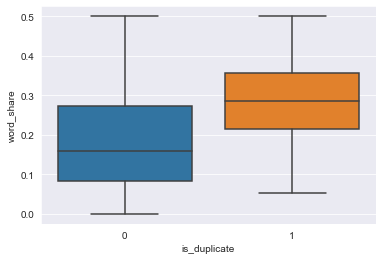

In [109]:
plt.figure()
sns.boxplot(x='is_duplicate', y='word_share', data=df)
plt.show();

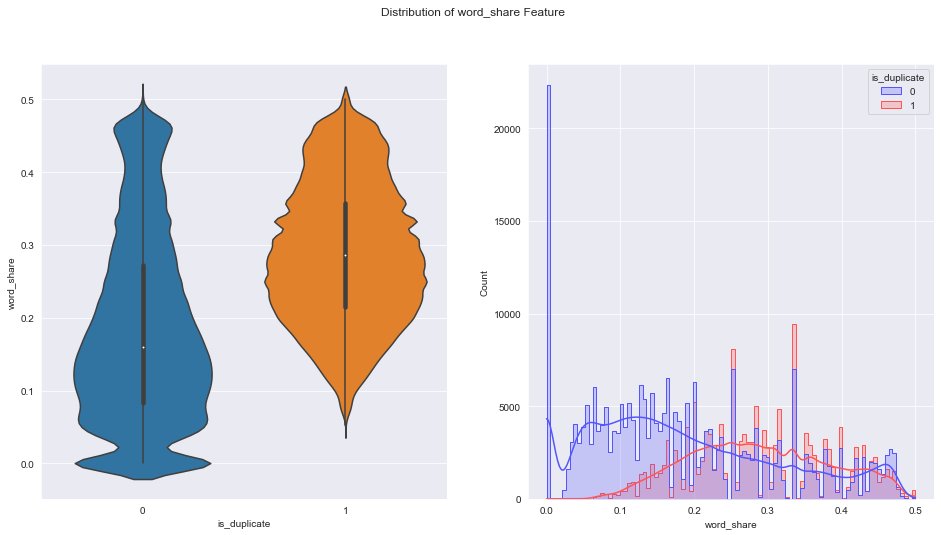

In [112]:
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
sns.violinplot(x='is_duplicate', y='word_share', data=df)

plt.subplot(1, 2, 2)
sns.histplot(x='word_share', data=df, hue='is_duplicate', kde=True, element='step', palette='seismic')

plt.suptitle('Distribution of word_share Feature')
plt.show();

- The distributions for `word_share` have some overlap towards the right side, i.e. there are a lot of questions with high word similarity.
- The average word share and Common number of words of qid1 and qid2 is more when they are duplicate(Similar)

***Feature - `word_common`***

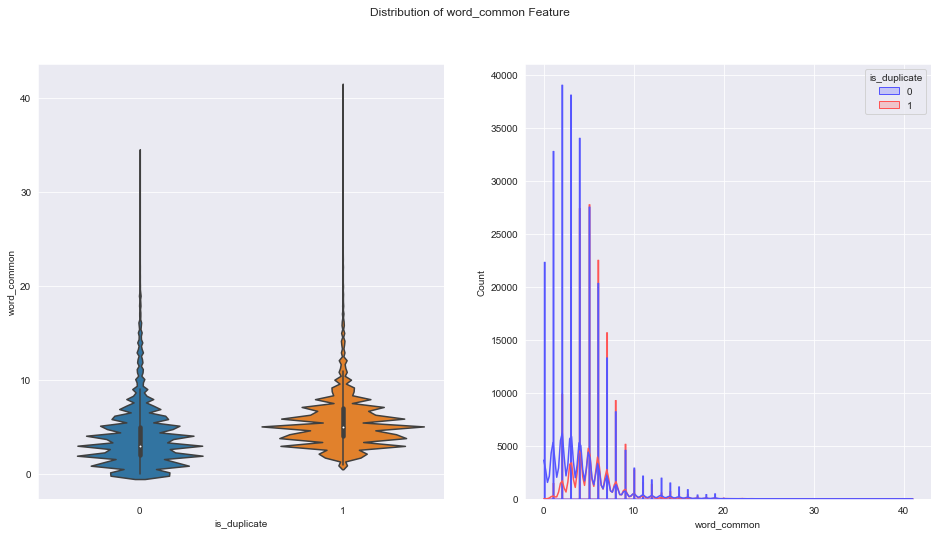

In [113]:
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
sns.violinplot(x='is_duplicate', y='word_common', data=df)

plt.subplot(1, 2, 2)
sns.histplot(x='word_common', data=df, hue='is_duplicate', kde=True, element='step', palette='seismic')
plt.suptitle('Distribution of word_common Feature')
plt.show();

- The distribution of `word_common` in Similar and Non-Similar questions is highly overlapping and same.

##### Preprocessing the TEXT

In [2]:
STOP_WORDS = stopwords.words("english")
SAFE_DIV = 0.0001  # so that we dont dvide by 0 accidently

In [17]:
def preprocess(x):
    x = str(x).lower()  # converting text to lowercase 
    
    # exapnding contractions (won't --> will not etc.) 
    x = (x.replace(',000,000', 'm').replace(',000', 'k').replace("′", "'").replace("’", "'")
         .replace("won't", "will not").replace('cannot', 'can not').replace("can't", 'can not')
         .replace("n't", ' not').replace("what's", "what is").replace("it's", "it is")
         .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are").replace("'ll", " will")
         .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")
         .replace("%", " percent").replace("₹", " rupees ").replace("$", " dollars ").replace("€", " euros ")
        )
    
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, " ", x)
        
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
        
    return x

In [18]:
# finding questions with html tags in them
i = 0
for sent in df['question1'].values:
    if len(re.findall('<.*?>', sent)):
        print(i)
        print(sent)
    i += 1

21502
Question- 30^30 - 29^30 whole divided by 30^29 + 29^29 is equal to x. Options- 1) x=1 2) x<1 3) x>1 4) cannot be determined?
27966
Did you know <*/\*>1800*-251-*4919*-*<*/\*> Belkin router Technical support Belkin customer phone number?
28609
“><img src=x onerror=prompt(1)>
33357
Is this the correct way to implement a stack using an arrayList<Integer> and a queue as an arrayList<Integer> in Java?
42742
What is the function of <head> <title>Page Title</title> </head> in HTML?
44844
How do you make one <div> layer show over another in HTML/CSS?
54206
Avg antivirus 1800</v\>251<’-‘>4919 Avg tech support phone number 24x7?
59220
How can one define a constant <img> src URL in HTML, so that it can be reused in multiple attributes?
60039
What is #include<stdio.h>?
67100
How do I open a windows file/folders in local drive using html "<a href>" tag?
75790
Avg antivirus 1800</v\>251<’-‘>4919 Avg tech support phone number 24x7?
103511
What is #include<stdio.h>?
109322
How can I write a prog

- *Here we can see that html tags are a part of the question, therefore we wont remove html tags from the questions.*

##### Advance Feature Engineering 

***Token*** - tokens are all the words present in the document (gotten by splitting the document)

***Stop_word*** - stop words as per NLTK.

***Words*** - A token which is not a stop word.

- **cwc_min** - Ratio of common_word_count to minimum length of word count in Question 1 and 2.
- **cwc_max** - Ratio of common_word_count to maximum length of word count in Question 1 and 2.


- **csc_min** - Ratio of common_stopwords_count to minimum length of word count in Question 1 and 2.
- **csc_max** - Ratio of common_stopwords_count to maximum length of word count in Question 1 and 2.


- **ctc_min** - Ratio of common_token_count to minimum length of word count in Question 1 and 2.
- **ctc_max** - Ratio of common_token_count to maximum length of word count in Question 1 and 2.


- **last_word_eq** - Checking if last word of both the questions are same.
- **first_word_eq** - Checking if first word of both the questions are same.


- **abs_len_diff** - Absoulte difference in length of tokens in both the questions.
- **mean_len** - Average token length of both the questions.


***Similarity features:***
- **fuzz_ratio** - Similarity of sentences.
- **fuzz_partial_ratio**
- **token_sort_ratio**
- **token_set_ratio**


- **longest_substr_ratio** - Ratio of length of longest common substring to min length of token count of questions 1 and 2.

In [48]:
# Function to get the token features
def get_token_features(q1, q2):
    token_features = [0.0] * 10
    
    # converting the document into tokens
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    
    # getting non-stopwords from the sentences
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    # getting the stopwords
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # getting the common_word_count
    common_word_count = len(list(set(q1_words) & set(q2_words)))
    
    # getting the common_stops_count
    common_stopword_count = len(list(set(q1_stops) & set(q2_stops)))
    
    # getting the common_token_count
    common_token_count = len(list(set(q1_tokens) & set(q2_tokens)))
    
    
    # now creating the features
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stopword_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[3] = common_stopword_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    token_features[9] = (len(q1_tokens) + len(q2_tokens)) / 2
    
    return token_features

# function to get the longest common substring 
def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

##### Extracting the Features that we have created 

In [49]:
def extract_features(df):
    # preprocessing each question
    df['question1'] = df['question1'].fillna("").apply(preprocess)
    df['question2'] = df['question2'].fillna("").apply(preprocess)
    
    print("Extracting TOKEN FEATURES...")
    token_features = df.apply(lambda x : get_token_features(x['question1'], x['question2']), axis=1)
    
    # mapping the features with the records
    df['cwc_min'] = list(map(lambda x: x[0], token_features))
    df['cwc_max'] = list(map(lambda x: x[1], token_features)) 
    df['csc_min'] = list(map(lambda x: x[2], token_features))
    df['csc_max'] = list(map(lambda x: x[3], token_features))
    df['ctc_min'] = list(map(lambda x: x[4], token_features))
    df['ctc_max'] = list(map(lambda x: x[5], token_features))
    df['last_word_eq'] = list(map(lambda x: x[6], token_features))
    df['first_word_eq'] = list(map(lambda x: x[7], token_features))
    df['abs_len_diff'] = list(map(lambda x: x[8], token_features))
    df['mean_len'] = list(map(lambda x: x[9], token_features))
    
    # computing the fuzzy features and adding to df
    print("Extracting FUZZY FEATURES...")
    
    df['token_set_ratio'] = df.apply(lambda x: fuzz.token_set_ratio(x['question1'], x['question2']), axis=1)
    df['token_sort_ratio'] = df.apply(lambda x: fuzz.token_sort_ratio(x['question1'], x['question2']), axis=1)
    df['fuzz_ratio'] = df.apply(lambda x: fuzz.QRatio(x['question1'], x['question2']), axis=1)
    df['fuzz_partial_ratio'] = df.apply(lambda x: fuzz.partial_ratio(x['question1'], x['question2']), axis=1)
    df['longest_substr_ratio'] = df.apply(lambda x: get_longest_substr_ratio(x['question1'], x['question2']), axis=1)
    
    return df

In [3]:
# applying the function:

if os.path.isfile('data/nlp_features_train.csv'):
    df = pd.read_csv("data/nlp_features_train.csv", encoding='latin-1')
    df.fillna('')

else:
    print('Extracting features for training...')
    df = pd.read_csv("data/train.csv")
    df = extract_features(df)
    df.to_csv('data/nlp_features_train.csv', index=False)

##### Analyzing Extracted Features

In [4]:
df_duplicate = df[df['is_duplicate'] == 1]
df_nonduplicate = df[df['is_duplicate'] == 0]

In [4]:
# getting all the questions from duplicate and non-duplicate dataframes
p = np.dstack([df_duplicate['question1'], df_duplicate['question2']]).flatten()
n = np.dstack([df_nonduplicate['question1'], df_nonduplicate['question2']]).flatten()

In [5]:
print("Number of data points in class 1 (duplicate pairs):", len(p))
print("Number of data points in class 0 (non-duplicate pairs):", len(n))

Number of data points in class 1 (duplicate pairs): 298526
Number of data points in class 0 (non-duplicate pairs): 510054


In [57]:
p, n

(array(['astrology  i am a capricorn sun cap moon and cap rising   what does that say about me ',
        'i am a triple capricorn  sun  moon and ascendant in capricorn  what does this say about me ',
        'how can i be a good geologist ', ...,
        'what does jainism say about gays and homosexuality ',
        'do you believe there is life after death ',
        'is it true that there is life after death '], dtype=object),
 array(['what is the step by step guide to invest in share market in india ',
        'what is the step by step guide to invest in share market ',
        'what is the story of kohinoor  koh i noor  diamond ', ...,
        'i am having little hairfall problem but i want to use hair styling product  which one should i prefer out of gel  wax and clay ',
        'what is like to have sex with cousin ',
        'what is it like to have sex with your cousin '], dtype=object))

In [72]:
# saving the numpy array as text files:
if not os.path.isfile('data/train_p.txt'):
    np.savetxt('data/train_p.txt', p, delimiter=' ', fmt='%s', encoding='utf-8')
    
if not os.path.isfile('data/train_n.txt'):
    np.savetxt('data/train_n.txt', n, delimiter=' ', fmt='%s', encoding='utf-8')

In [5]:
# reading the text file and removing stop words from the questions:

textp_w = open('data/train_p.txt', encoding='utf-8').read()
textn_w = open('data/train_n.txt', encoding='utf-8').read()

stopwords = set(STOP_WORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")
stopwords.remove("no")
# stopwords.remove("like")
# stopwords.remove('good')
# stopwords.remove('love')
# stopwords.remove('best')

print(f"Total number of words in duplicate pair questions: {len(textp_w)}")
print(f"Total number of words in non duplicate pair questions: {len(textn_w)}")

Total number of words in duplicate pair questions: 16111097
Total number of words in non duplicate pair questions: 33193881


*Creating WordClouds from Duplicate Pair Questions*

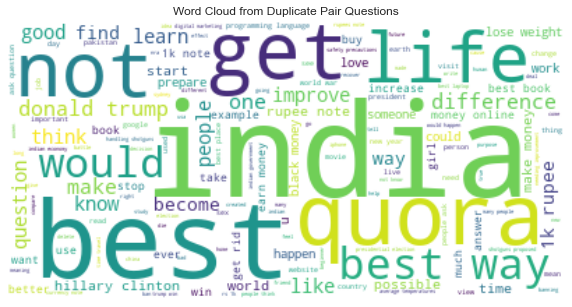

In [85]:
wc = WordCloud(background_color="white", max_words=len(textp_w), stopwords=stopwords)
wc.generate(textp_w)

plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation='bilinear')
plt.title('Word Cloud from Duplicate Pair Questions')
plt.axis(False)
plt.show();

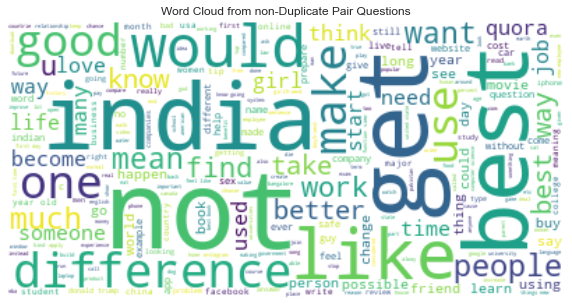

In [86]:
wc = WordCloud(background_color='white', max_words=len(textn_w), stopwords=stopwords)
wc.generate(textn_w)

plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation='bilinear')
plt.title('Word Cloud from non-Duplicate Pair Questions')
plt.axis(False)
plt.show();

##### Visualizing the Features Engineered (Extracted)

In [ ]:
# plotting a pair plot between the features 
variables = ['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']
plt.figure()
sns.pairplot(df, vars=variables, palette='viridis', diag_kind='hist')
plt.show();

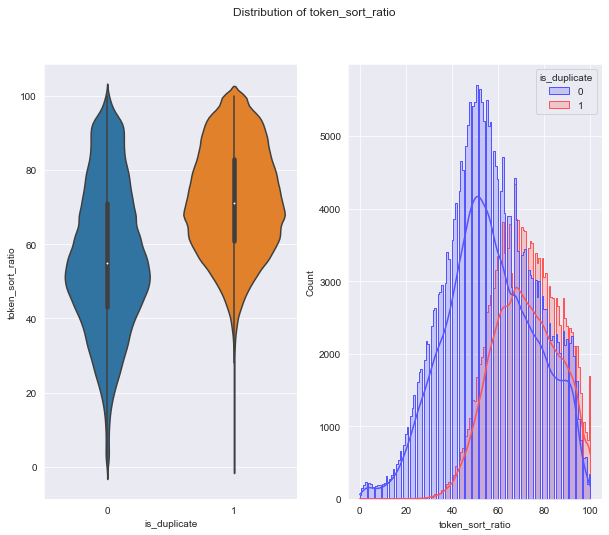

In [89]:
# Distribution of token_sort_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1, 2, 1)
sns.violinplot(x='is_duplicate', y='token_sort_ratio', data=df)

plt.subplot(1, 2, 2)
sns.histplot(x='token_sort_ratio', hue='is_duplicate', data=df, element='step', kde=True, palette='seismic')
plt.suptitle('Distribution of token_sort_ratio')
plt.show();

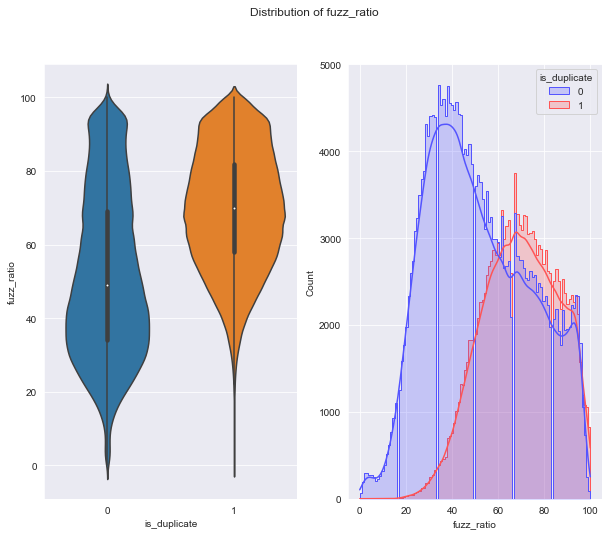

In [90]:
# Distribution of fuzz_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1, 2, 1)
sns.violinplot(x='is_duplicate', y='fuzz_ratio', data=df)

plt.subplot(1, 2, 2)
sns.histplot(x='fuzz_ratio', hue='is_duplicate', data=df, element='step', kde=True, palette='seismic')
plt.suptitle('Distribution of fuzz_ratio')
plt.show();

##### Visualizing using T-SNE

In [8]:
# visualizing and reducing dimension of a sample of training data
dfp_sampled = df[:5000]
dfp_sampled.shape

(5000, 21)

In [9]:
# scaling X and getting y
X = MinMaxScaler().fit_transform(dfp_sampled[
    ['cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max', 'last_word_eq', 'first_word_eq', 
     'mean_len', 'token_set_ratio', 'token_sort_ratio', 'abs_len_diff',
     'fuzz_ratio', 'fuzz_partial_ratio', 'longest_substr_ratio']
])
y = dfp_sampled['is_duplicate'].values

*Applying TSNE, reducing to 2 dimensions*

In [10]:
tsne2d = TSNE(n_components=2,
             init='random',
             random_state=42,
             method='barnes_hut',
             n_iter=1000,
             verbose=2,
             angle=0.5).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.034s...
[t-SNE] Computed neighbors for 5000 samples in 0.370s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.095684
[t-SNE] Computed conditional probabilities in 0.275s
[t-SNE] Iteration 50: error = 82.3457031, gradient norm = 0.0513273 (50 iterations in 1.378s)
[t-SNE] Iteration 100: error = 70.3179855, gradient norm = 0.0106983 (50 iterations in 1.041s)
[t-SNE] Iteration 150: error = 68.4764252, gradient norm = 0.0061155 (50 iterations in 1.003s)
[t-SNE] Iteration 200: error = 67.6691284, gradient norm = 0.0038604 (50 iterations in 1.005s)
[t-SNE] Iteration 250: error = 67.2059021, gradient norm = 0.0043204

In [12]:
print(tsne2d)
print("Shape: ", tsne2d.shape)

[[ 64.68148     9.441901 ]
 [ 49.599678  -23.040258 ]
 [ 23.289019  -48.703663 ]
 ...
 [ 12.219295   31.467121 ]
 [ -0.6414442 -18.494862 ]
 [ -3.7828581   6.2027373]]
Shape:  (5000, 2)


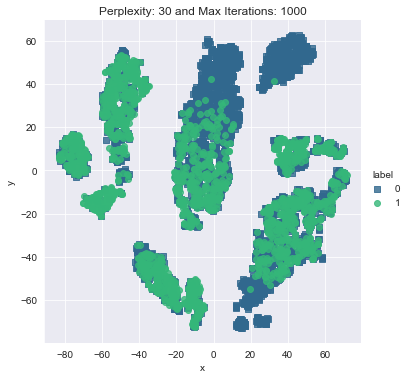

In [20]:
# plotting the results of TSNE:
tsne_df = pd.DataFrame({
    'x': tsne2d[:, 0],
    'y': tsne2d[:, 1],
    'label': y
})


g = sns.lmplot(data=tsne_df, x='x', y='y', hue='label', palette='viridis', markers=['s', 'o'], fit_reg=False)
plt.title(f"Perplexity: {30} and Max Iterations: {1000}")
plt.show();

##### TFIDF Weighted Word-Vectors

In [22]:
# importing the train data
df = pd.read_csv('data/train.csv')

In [23]:
# encoding questions to str
df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))

In [25]:
type(df['question1'].iloc[0])

str

In [26]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [27]:
# merging the texts (both question1 and question2)
questions = list(df['question1']) + list(df['question2'])

*Creating the TF-IDF object and fitting to the questions*

In [28]:
tfidf = TfidfVectorizer(lowercase=False)
tfidf.fit_transform(questions)

<808580x109679 sparse matrix of type '<class 'numpy.float64'>'
	with 8146555 stored elements in Compressed Sparse Row format>

In [29]:
# dictionary -> key: word and value: tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

- Now we have the tf-idf score for each word(token)
- Now we convert each question to a weighted average of word2vec vectors by these tf-idf scores.

- We will use a pretrained GLOVE model in the SpaCy library, which is trained on Wikipedia.


In [36]:
nlp = spacy.load('en_core_web_sm')

*Creating the vectors for both Question1 and Question2.*

In [38]:
# question1
vectors1 = []

for question in tqdm(list(df['question1'])):
    doc = nlp(question)
    mean_vec1 = np.zeros([len(doc), len(doc[0].vector)])
    
    for word in doc:
        vec1 = word.vector
        # getting the tf-idf score:
        try:
            idf = word2tfidf[str(word)]
        except:
            idf = 0
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vectors1.append(mean_vec1)
    
df['q1_feats_m'] = list(vectors1)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 404290/404290 [1:00:18<00:00, 111.74it/s]


In [39]:
# question2
vectors2 = []

for question in tqdm(list(df['question2'])):
    doc = nlp(question)
    mean_vec2 = np.zeros([len(doc), len(doc[0].vector)])
    
    for word in doc:
        vec2 = word.vector
        # getting the tf-idf score:
        try:
            idf = word2tfidf[str(word)]
        except:
            idf = 0
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vectors2.append(mean_vec2)
    
df['q2_feats_m'] = list(vectors2)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 404290/404290 [1:05:35<00:00, 102.73it/s]


In [40]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_feats_m,q2_feats_m
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,"[43.67006292939186, -18.895203411579132, 31.04...","[40.365840286016464, -18.171502977609634, 26.6..."
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,"[-9.84411402605474, -40.796672493219376, 52.65...","[2.7210964602418244, -38.60602626204491, 42.33..."
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,"[35.13538068532944, -1.722997047007084, -0.510...","[26.818276420235634, -12.202365696430206, 17.5..."
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,"[-19.42189860343933, -8.17663848400116, 16.911...","[6.5864250510931015, -12.578705340623856, -1.8..."
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,"[13.579602181911469, -25.496062636375427, 54.3...","[22.647420465946198, -15.131731376051903, 9.63..."


In [50]:
# looking at the shape of a vector:
(df['q1_feats_m'].iloc[10]).shape

(96,)

In [51]:
# loading all the data that we have so far:

if os.path.isfile('data/nlp_features_train.csv'):
    dfnlp = pd.read_csv('data/nlp_features_train.csv', encoding='latin-1')
else:
    print("Error occured, file 'data/nlp_features_train.csv' not found")
    
if os.path.isfile('data/df_fe_without_preprocessing_training.csv'):
    dfppro = pd.read_csv('data/df_fe_without_preprocessing_training.csv', encoding='latin-1')
else:
    print("Error occured, file 'data/df_fe_without_preprocessing_training.csv' not found.")

In [52]:
# Dropping columns and just keeping the features:
df1 = dfnlp.drop(['qid1','qid2','question1','question2'], axis=1)
df2 = dfppro.drop(['qid1','qid2','question1','question2', 'is_duplicate'], axis=1)
df3 = df.drop(['qid1','qid2','question1','question2', 'is_duplicate'], axis=1)

df3_q1 = pd.DataFrame(df3.q1_feats_m.values.tolist(), index=df3.index)
df3_q2 = pd.DataFrame(df3.q2_feats_m.values.tolist(), index=df3.index)

*Looking at the NLP features:*

In [53]:
df1.head()

,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,0,0.999980,0.833319,1.199976,0.999983,2.199956,1.833303,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,0,0.799984,0.399996,0.599988,0.299997,1.399972,0.699993,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,0,0.399992,0.333328,0.399992,0.333328,0.799984,0.666656,0.0,1.0,4.0,12.0,63,63,43,47,0.166667
3,3,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,12.0,28,24,9,14,0.039216
4,4,0,0.399992,0.199998,0.399992,0.199998,0.799984,0.399996,0.0,1.0,6.0,10.0,67,47,35,56,0.175000


*Data with Feature Engineering without Preprocessing:*

In [54]:
df2.head()

,id,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_common,word_total,word_share,freq1+2,freq1-2
0,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


*Question1 TF-IDF weighted word2vec:*

In [55]:
df3_q1.head()

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,43.670063,-18.895203,31.045513,-2.327918,6.752804,-10.280105,-2.178911,3.109268,-8.114966,-3.354371,...,35.302443,-45.297104,1.763982,-2.177900,-14.906988,22.325749,33.975355,-15.763256,23.618216,20.205125
1,-9.844114,-40.796672,52.653931,0.270138,4.557999,-12.078969,-30.232627,6.523269,-21.541085,-23.842775,...,23.405379,-50.315190,-6.168633,20.593875,5.565464,-5.659679,25.576985,1.491194,16.132743,18.459342
2,35.135381,-1.722997,-0.510308,13.738739,10.017380,-11.578707,-16.146953,-2.431097,-10.274281,-15.073572,...,1.471378,-4.810862,5.507978,-0.858382,6.748774,17.007017,7.381846,5.746808,-11.446529,-12.614950
3,-19.421899,-8.176638,16.911288,-7.714190,-9.332053,4.819086,-10.924757,-28.115831,0.156545,-20.135813,...,-3.566931,-21.736962,14.846244,20.713393,-2.741195,7.802307,-24.368381,-20.642483,14.605099,-6.161306
4,13.579602,-25.496063,54.301285,-22.507244,-18.902611,-42.016124,-20.796953,27.801866,-18.595385,7.753244,...,-2.988818,-61.677020,-41.410480,6.023759,5.388558,-16.150755,92.499480,-45.504365,33.196220,41.812422


*Question2 TF-IDF weighted word2vec:*

In [56]:
df3_q2.head()

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,40.365840,-18.171503,26.689361,-2.617072,5.759337,-13.631582,3.199559,10.659402,-7.587867,-3.637427,...,23.763565,-37.972196,4.817606,-3.098755,-14.260972,13.417170,20.494512,-12.179840,18.291334,15.312469
1,2.721096,-38.606026,42.339675,17.295721,-11.639005,19.568940,-38.951293,-13.131492,-22.818469,-20.102131,...,9.721871,-53.412668,-10.705596,8.075593,-15.199417,-19.734515,11.872082,-7.760315,4.839641,14.452543
2,26.818276,-12.202366,17.538920,2.143137,6.296759,-3.888345,5.009675,-18.836100,19.549915,-8.767063,...,-8.362682,0.975083,-1.032936,-7.203513,-17.560499,11.624947,-7.443854,9.523095,28.918900,-5.387842
3,6.586425,-12.578705,-1.812264,-2.481224,16.855381,20.920213,-8.789817,-18.612814,-13.778669,-2.127370,...,-3.755800,-11.272430,5.350519,-0.904006,-2.060986,-1.909355,-9.499200,2.505714,16.132606,-3.053620
4,22.647420,-15.131731,9.634974,-1.350771,5.857454,-10.887629,-9.042155,12.270401,-0.953333,-7.289259,...,2.506907,-8.654343,-0.557679,5.026155,-8.514976,-5.216982,12.199519,-3.763349,-13.701407,1.028146


In [57]:
# Features:
print(f"Number of features in NLP dataframe: {dfnlp.shape[1]}")
print(f"Number of features in preprocessed dataframe: {dfppro.shape[1]}")
print(f"Number of features in question1 word2vec dataframe: {df3_q1.shape[1]}")
print(f"Number of features in question2 word2vec dataframe: {df3_q2.shape[1]}")
print(f"Total Features: {dfnlp.shape[1] + dfppro.shape[1] + df3_q1.shape[1] + df3_q2.shape[1]}")

Number of features in NLP dataframe: 21
Number of features in preprocessed dataframe: 17
Number of features in question1 word2vec dataframe: 96
Number of features in question2 word2vec dataframe: 96
Total Features: 230


In [61]:
# storing the final features:
if not os.path.isfile('data/final_features.csv'):
    df3_q1['id']=df1['id']
    df3_q2['id']=df1['id']
    df1=df1.merge(df2, on='id',how='left')
    df2=df3_q1.merge(df3_q2, on='id',how='left')
    result=df1.merge(df2, on='id',how='left')
    result.to_csv('data/final_features.csv', index=False)